In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from torchgeo.datasets import NAIP

from configs import config
from data.kc import KaneCounty

# Assuming KaneCounty class is defined in a separate module 'KaneCounty_module.py'
# or in a previous cell. If it's in a separate file, you would do:
# from KaneCounty_module import KaneCounty

# Initialize the dataset
naip_dataset = NAIP(config.KC_IMAGE_ROOT)
shape_path = Path(config.KC_SHAPE_ROOT) / config.KC_SHAPE_FILENAME
dataset_config = (
    config.KC_LAYER,
    config.KC_LABELS,
    config.PATCH_SIZE,
    naip_dataset.crs,
    naip_dataset.res,
)
kc_dataset = KaneCounty(shape_path, dataset_config)

# Define the labels mapping
# Make sure these strings match exactly the BasinType values in your GPKG
labels = {
    "BACKGROUND": 0,
    "POND": 1,
    "WETLAND": 2,
    "DRY BOTTOM - TURF": 3,
    "DRY BOTTOM - MESIC PRAIRIE": 4,
}

# Access the GeoDataFrame
gdf = kc_dataset.gdf

# Compute the area in the dataset CRS
# Ensure that the CRS is projected. If not, reproject:
# gdf = gdf.to_crs("EPSG:<projected_crs_code>")
gdf["area"] = gdf["geometry"].area

# Filter the GDF to only include your 5 classes of interest
# Note: if your GPKG contains more classes, this ensures only the 5 mentioned are included
class_names_of_interest = labels.keys()  # ["BACKGROUND", "POND", "WETLAND", "DRY BOTTOM - TURF", "DRY BOTTOM - MESIC PRAIRIE"]
gdf_filtered = gdf[gdf["BasinType"].isin(class_names_of_interest)]

# Compute frequency (occurrence) of each class
class_counts = gdf_filtered["BasinType"].value_counts()

# Compute total area per class
class_areas = gdf_filtered.groupby("BasinType")["area"].sum()

# Convert to DataFrame for easier plotting
df_stats = (
    class_counts.rename("count")
    .to_frame()
    .join(class_areas.rename("total_area"))
    .reset_index()
    .rename(columns={"index": "BasinType"})
)

# Map BasinType to class_id if needed
df_stats["class_id"] = df_stats["BasinType"].map(labels)

df_stats

,BasinType,count,total_area,class_id
0,POND,2375,1.702098e+07,1
1,WETLAND,1655,9.540348e+06,2
2,DRY BOTTOM - TURF,936,2.831817e+06,3
3,DRY BOTTOM - MESIC PRAIRIE,223,1.074185e+06,4


/tmp/ipykernel_1880609/2470960303.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="BasinType", y="count", data=df_stats, palette="viridis")


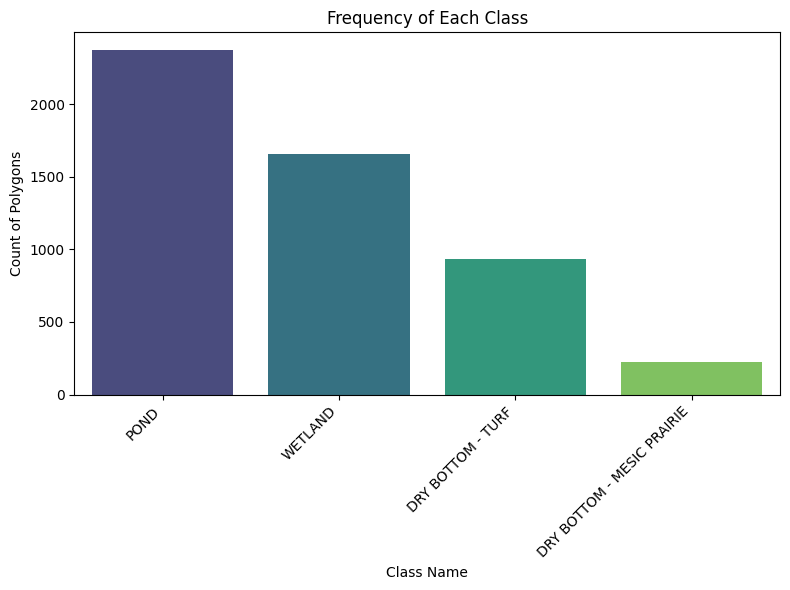

/tmp/ipykernel_1880609/2470960303.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="BasinType", y="total_area", data=df_stats, palette="plasma")


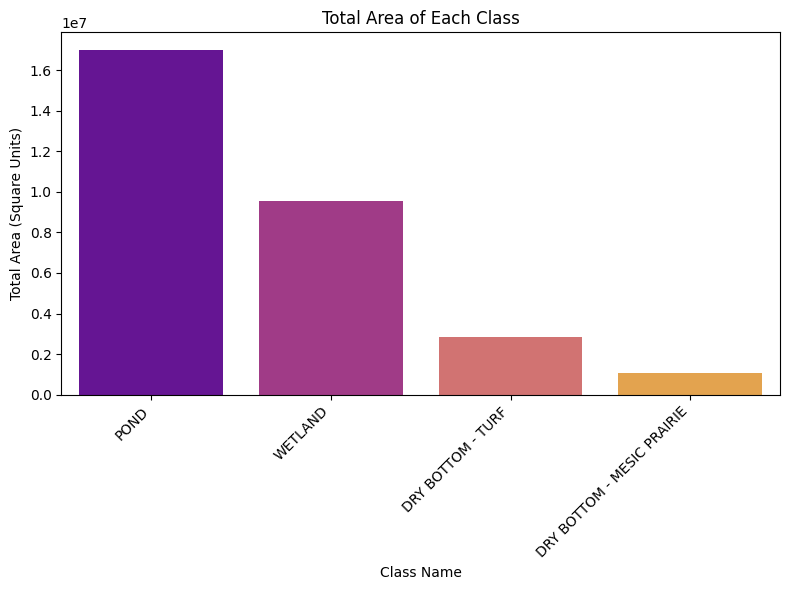

In [4]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x="BasinType", y="count", data=df_stats, palette="viridis")
plt.title("Frequency of Each Class")
plt.xlabel("Class Name")
plt.ylabel("Count of Polygons")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x="BasinType", y="total_area", data=df_stats, palette="plasma")
plt.title("Total Area of Each Class")
plt.xlabel("Class Name")
plt.ylabel("Total Area (Square Units)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()